In [0]:
import zipfile as zf
files=zf.ZipFile("train.zip",'r')
files.extractall(path="train", members=None, pwd=None)

In [0]:
#Import some packages to use
import cv2
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline 

#To see our directory
import os
import random
import gc   #Garbage collector for cleaning deleted data from memory



In [0]:
!

In [100]:


train_dir = '/root/train/'


train_dogs = ['/root/train/{}'.format(i) for i in os.listdir(train_dir) if 'dog' in i]  #get dog images
train_cats = ['/root/train/{}'.format(i) for i in os.listdir(train_dir) if 'cat' in i]  #get cat images

train_imgs = train_dogs[:2000] + train_cats[:2000]  # slice the dataset and use 2000 in each class
random.shuffle(train_imgs)  # shuffle it randomly

#Clear list that are useless
#del train_dogs

#del train_cats
gc.collect()   #collect garbage to save memory

53

In [0]:
# import matplotlib.image as mpimg
# for ima in train_imgs[0:3]:
#     img=mpimg.imread(ima)
#     imgplot = plt.imshow(img)
#     plt.show()

In [0]:
#Lets declare our image dimensions
#we are using coloured images. 
nrows = 150
ncolumns = 150
channels = 3  #change to 1 if you want to use grayscale image


#A function to read and process the images to an acceptable format for our model
def read_and_process_image(list_of_images):
    """
    Returns two arrays: 
        X is an array of resized images
        y is an array of labels
    """
    X = [] # images
    y = [] # labels
    
    for image in list_of_images:
        X.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR), (nrows,ncolumns), interpolation=cv2.INTER_CUBIC))  #Read the image
        #get the labels
        if 'dog' in image:
            y.append(1)
        elif 'cat' in image:
            y.append(0)
    
    return X, y

In [0]:
#get the train and label data
X, y = read_and_process_image(train_imgs)

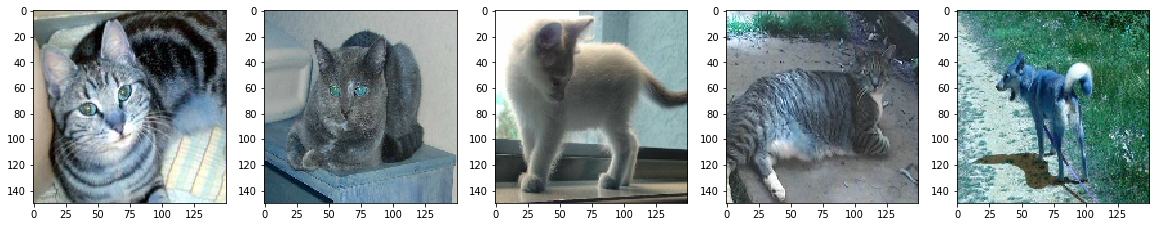

In [103]:
#Lets view some of the pics
plt.figure(figsize=(20,10))
columns = 5
for i in range(columns):
    plt.subplot(5 / columns + 1, columns, i + 1)
    plt.imshow(X[i])


Text(0.5, 1.0, 'Labels for Cats and Dogs')

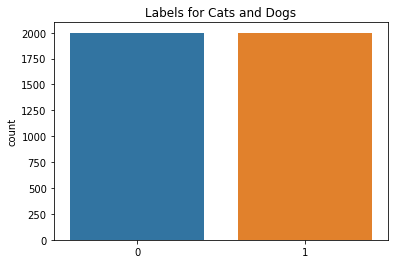

In [104]:
import seaborn as sns
gc.collect()

#Convert list to numpy array
X = np.array(X)
y = np.array(y)

#Lets plot the label to be sure we just have two class
sns.countplot(y)
plt.title('Labels for Cats and Dogs')

In [105]:
print("Shape of train images is:", X.shape)
print("Shape of labels is:", y.shape)

Shape of train images is: (4000, 150, 150, 3)
Shape of labels is: (4000,)


In [106]:
#Lets split the data into train and test set
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.3)

print("Shape of train images is:", X_train.shape)
print("Shape of validation images is:", X_val.shape)
print("Shape of labels is:", y_train.shape)
print("Shape of labels is:", y_val.shape)

Shape of train images is: (2800, 150, 150, 3)
Shape of validation images is: (1200, 150, 150, 3)
Shape of labels is: (2800,)
Shape of labels is: (1200,)


In [0]:
#clear memory
del X
del y
gc.collect()

#get the length of the train and validation data
ntrain = len(X_train)
nval = len(X_val)

#We will use a batch size of 32. Note: batch size should be a factor of 2.***4,8,16,32,64...***
batch_size = 32 


Now lets create our model.

In [0]:
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))  #Dropout for regularization
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))  #Sigmoid function at the end because we have just two classes

In [109]:
#Lets see our model
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)      

In [0]:
#We'll use the RMSprop optimizer with a learning rate of 0.0001
#We'll use binary_crossentropy loss because its a binary classification
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])

In [0]:
#Lets create the augmentation configuration
#This helps prevent overfitting, since we are using a small dataset
train_datagen = ImageDataGenerator(rescale=1./255,   #Scale the image between 0 and 1
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,)

val_datagen = ImageDataGenerator(rescale=1./255)  #We do not augment validation data. we only perform rescale

In [0]:
#Create the image generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

In [115]:
#The training part
#We train for 64 epochs with about 100 steps per epoch,accuracy will be 80%
history = model.fit_generator(train_generator,
                              steps_per_epoch=30,
                              epochs=64,
                              validation_data=val_generator,
                              validation_steps=nval // batch_size)

Epoch 1/64
30/30 [==============================] - 55s 2s/step - loss: 0.6115 - acc: 0.6635 - val_loss: 0.5846 - val_acc: 0.6791
Epoch 2/64
30/30 [==============================] - 53s 2s/step - loss: 0.6089 - acc: 0.6698 - val_loss: 0.6447 - val_acc: 0.6267
Epoch 3/64
30/30 [==============================] - 52s 2s/step - loss: 0.6052 - acc: 0.6470 - val_loss: 0.5893 - val_acc: 0.6738
Epoch 4/64
30/30 [==============================] - 53s 2s/step - loss: 0.6237 - acc: 0.6552 - val_loss: 0.5774 - val_acc: 0.6849
Epoch 5/64
30/30 [==============================] - 53s 2s/step - loss: 0.5902 - acc: 0.6625 - val_loss: 0.5974 - val_acc: 0.6729
Epoch 6/64
30/30 [==============================] - 52s 2s/step - loss: 0.6056 - acc: 0.6698 - val_loss: 0.6159 - val_acc: 0.6635
Epoch 7/64
30/30 [==============================] - 53s 2s/step - loss: 0.5855 - acc: 0.6760 - val_loss: 0.5690 - val_acc: 0.6918
Epoch 8/64
30/30 [==============================] - 52s 2s/step - loss: 0.6068 - acc: 0.66

In [0]:
#Save the model
model.save_weights('model_wieghts.h5')
model.save('model_keras.h5')

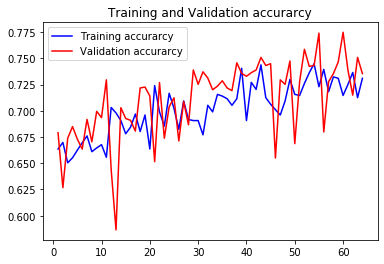

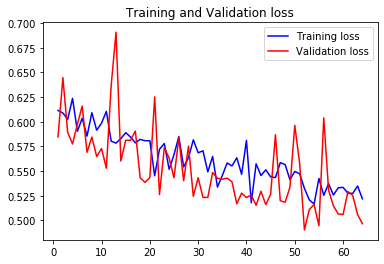

In [117]:
#lets plot the train and val curve
#get the details form the history object
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()


In [0]:
#Now lets predict on the first 10 Images of the test set
X_test, y_test = read_and_process_image(train_imgs[0:20]) #Y_test in this case will be empty.
x = np.array(X_test)
test_datagen = ImageDataGenerator(rescale=1./255) 

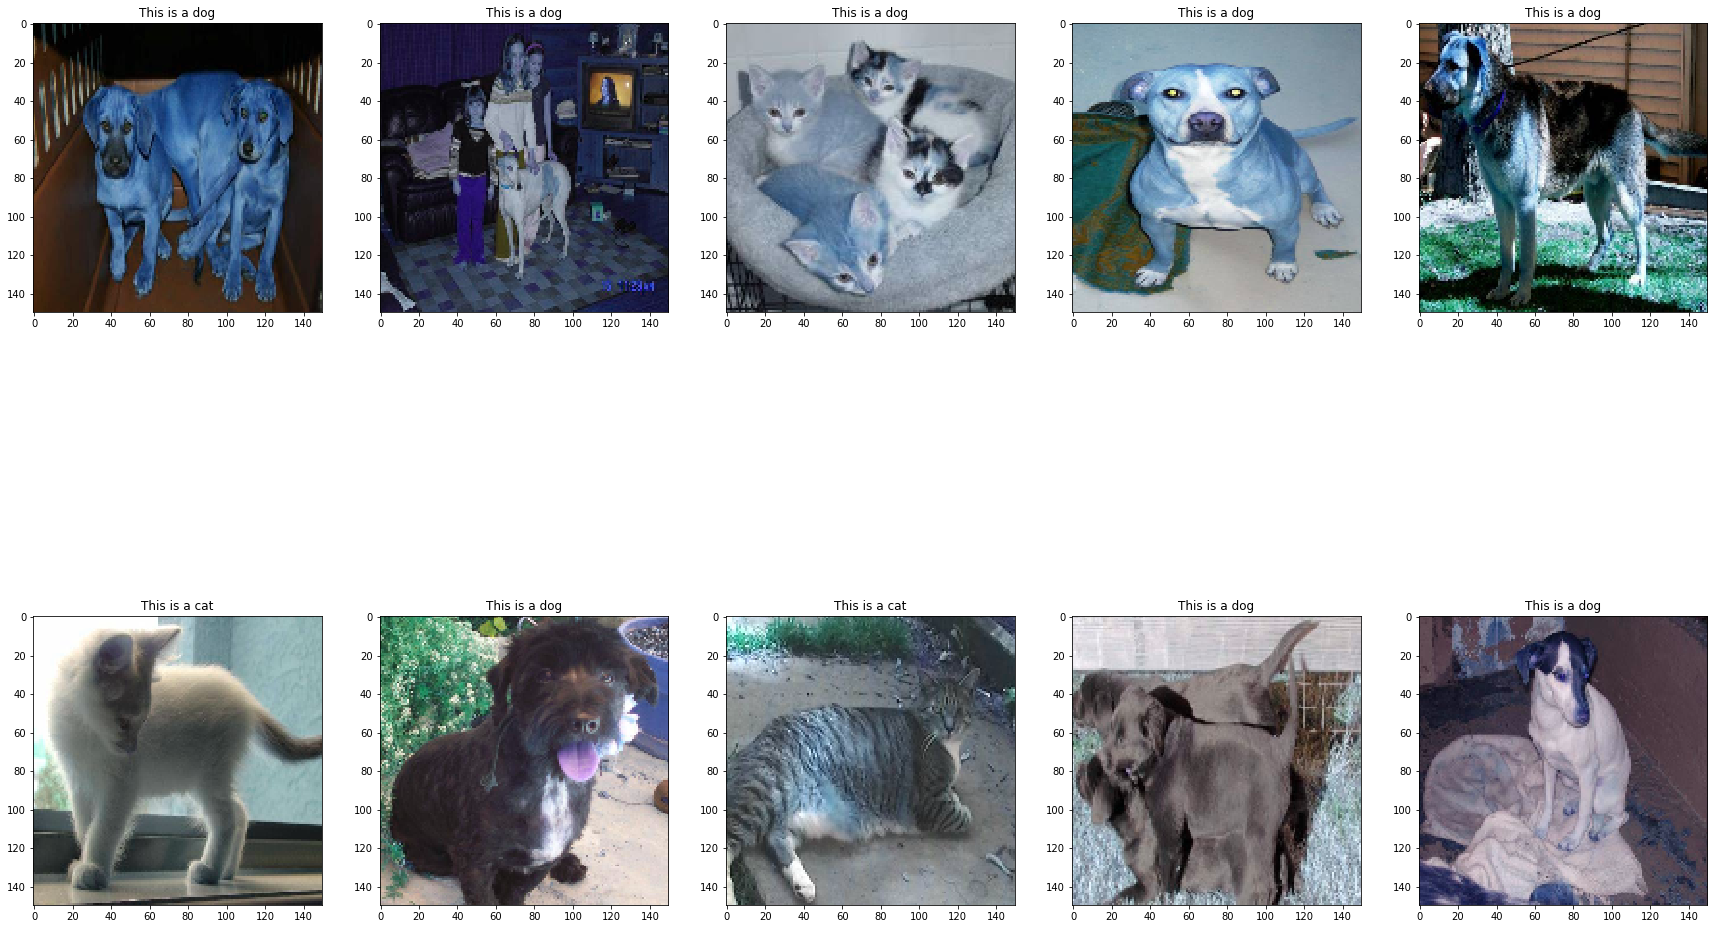

In [119]:
i = 0
text_labels = []
plt.figure(figsize=(30,20))
for batch in test_datagen.flow(x, batch_size=1):
    pred = model.predict(batch)
    if pred > 0.5:
        text_labels.append('dog')
    else:
        text_labels.append('cat')
    plt.subplot(5 / columns + 1, columns, i + 1)
    plt.title('This is a ' + text_labels[i])
    imgplot = plt.imshow(batch[0])
    i += 1
    if i % 10 == 0:
        break
plt.show()